# Broadband and Neighborhoods in NYC
- EDA on Neighborhood Tabulation Areas (NTA) and broadband access

In [184]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.set_option('display.max_columns', 100)

## Preparing NTA Demographic Data
**Data:** [NYC Open Data - Demographic Profiles of ACS 5 Year Estimates at the Neighborhood Tabulation Area (NTA) level (2016)](https://data.cityofnewyork.us/City-Government/Demographic-Profiles-of-ACS-5-Year-Estimates-at-th/8cwr-7pqn)

In [2]:
demo = pd.read_excel('./data/nta_demo_2016.xlsx')

In [116]:
demo.head(3)

,Neighborhood,GeoID,Borough,Male,Female,MdAgeE,PopU5,Pop5t9,Pop10t14,Pop15t19,Pop20t24,Pop25t29,Pop30t34,Pop35t39,Pop40t44,Pop45t49,Pop50t54,Pop55t59,Pop60t64,Pop65t69,Pop70t74,Pop75t79,Pop80t84,Pop85pl,PopU181,Pop65pl1,PopU18M,PopU18F,Pop65plM,Pop65plF,Hsp1,WtNH,BlNH,AIANNH,AsnNH,NHPINH,OthNH,Rc2plNH,HspMe,HspPR,HspCub,HspDom,HspCAm,HspSAm,HspOth,Asn1Rc,AsnEast,AsnSouth,AsnSEast,AsnOAsn,Asn2pl
0,Bath Beach,BK27,Brooklyn,0.503,0.497,38.3,0.067,0.055,0.058,0.050,0.052,0.086,0.084,0.074,0.074,0.067,0.064,0.065,0.058,0.043,0.031,0.024,0.024,0.025,0.214,0.147,0.566,0.434,0.431,0.569,0.177,0.437,0.012,0.000,0.361,0.001,0.002,0.010,0.228,0.293,0.022,0.040,0.230,0.149,0.039,1.0,0.855,0.097,0.032,0.004,0.013
1,Bay Ridge,BK31,Brooklyn,0.478,0.522,39.5,0.065,0.057,0.043,0.045,0.055,0.086,0.087,0.069,0.069,0.071,0.075,0.062,0.060,0.051,0.038,0.027,0.021,0.020,0.191,0.156,0.485,0.515,0.396,0.604,0.179,0.634,0.019,0.002,0.146,0.000,0.002,0.018,0.223,0.420,0.034,0.065,0.064,0.162,0.032,1.0,0.770,0.165,0.047,0.010,0.008
2,Bedford,BK75,Brooklyn,0.484,0.516,29.1,0.099,0.087,0.071,0.062,0.086,0.115,0.093,0.074,0.058,0.048,0.048,0.046,0.036,0.024,0.021,0.014,0.012,0.007,0.297,0.077,0.546,0.454,0.384,0.616,0.195,0.351,0.406,0.001,0.030,NaN,0.002,0.015,0.083,0.434,0.018,0.298,0.055,0.068,0.044,1.0,0.420,0.410,0.135,0.011,0.024


In [3]:
# Set relevant columns
geo = ['GeogName', 'GeoID', 'Borough']
misc = ['MaleP', 'FemP', 'MdAgeE']
pct = [
    col for col in demo.columns
    if col[-1] == 'P'
]
age = [
    col for col in pct
    if (col[:3] == 'Pop')
    and (col[-2] != '2')
]
race = [
    'Hsp1P', 'WtNHP', 'BlNHP', 'AIANNHP', 'AsnNHP', 'NHPINHP', 'OthNHP', 'Rc2plNHP',
    'HspMeP', 'HspPRP', 'HspCubP', 'HspDomP', 'HspCAmP', 'HspSAmP', 'HspOthP',
    'Asn1RcP', 'AsnEastP', 'AsnSouthP', 'AsnSEastP', 'AsnOAsnP', 'Asn2plP'
]
cols = geo + misc + age + race

In [4]:
# Keep relevant columns
demo = demo[cols]
demo.columns = [ col if col[-1] != 'P' else col[:-1] for col in demo.columns.tolist() ]
demo.drop(
    columns=['Pop_1'],
    inplace=True
)

In [5]:
# Clean and prepare columns names for merge
demo.rename(
    columns={'GeogName': 'Neighborhood', 'Fem': 'Female'},
    inplace=True
)
for col in demo.columns.tolist():
    if col not in ['Neighborhood', 'GeoID', 'Borough', 'MdAgeE']:
        demo[col] = demo[col] / 100

In [6]:
demo.head(3)

,Neighborhood,GeoID,Borough,Male,Female,MdAgeE,PopU5,Pop5t9,Pop10t14,Pop15t19,Pop20t24,Pop25t29,Pop30t34,Pop35t39,Pop40t44,Pop45t49,Pop50t54,Pop55t59,Pop60t64,Pop65t69,Pop70t74,Pop75t79,Pop80t84,Pop85pl,PopU181,Pop65pl1,PopU18M,PopU18F,Pop65plM,Pop65plF,Hsp1,WtNH,BlNH,AIANNH,AsnNH,NHPINH,OthNH,Rc2plNH,HspMe,HspPR,HspCub,HspDom,HspCAm,HspSAm,HspOth,Asn1Rc,AsnEast,AsnSouth,AsnSEast,AsnOAsn,Asn2pl
0,Bath Beach,BK27,Brooklyn,0.503,0.497,38.3,0.067,0.055,0.058,0.050,0.052,0.086,0.084,0.074,0.074,0.067,0.064,0.065,0.058,0.043,0.031,0.024,0.024,0.025,0.214,0.147,0.566,0.434,0.431,0.569,0.177,0.437,0.012,0.000,0.361,0.001,0.002,0.010,0.228,0.293,0.022,0.040,0.230,0.149,0.039,1.0,0.855,0.097,0.032,0.004,0.013
1,Bay Ridge,BK31,Brooklyn,0.478,0.522,39.5,0.065,0.057,0.043,0.045,0.055,0.086,0.087,0.069,0.069,0.071,0.075,0.062,0.060,0.051,0.038,0.027,0.021,0.020,0.191,0.156,0.485,0.515,0.396,0.604,0.179,0.634,0.019,0.002,0.146,0.000,0.002,0.018,0.223,0.420,0.034,0.065,0.064,0.162,0.032,1.0,0.770,0.165,0.047,0.010,0.008
2,Bedford,BK75,Brooklyn,0.484,0.516,29.1,0.099,0.087,0.071,0.062,0.086,0.115,0.093,0.074,0.058,0.048,0.048,0.046,0.036,0.024,0.021,0.014,0.012,0.007,0.297,0.077,0.546,0.454,0.384,0.616,0.195,0.351,0.406,0.001,0.030,NaN,0.002,0.015,0.083,0.434,0.018,0.298,0.055,0.068,0.044,1.0,0.420,0.410,0.135,0.011,0.024


## Preparing NTA Broadband Data
**Data:** [NYC Open Data - Internet Master Plan: Adoption and Infrastructure Data by Neighborhood (2021)](https://data.cityofnewyork.us/City-Government/Internet-Master-Plan-Adoption-and-Infrastructure-D/fg5j-q5nk)

In [7]:
import urllib
import json

In [8]:
r = urllib.request.urlopen('https://data.cityofnewyork.us/resource/fg5j-q5nk.json')
json_dict = json.load(r)
bb = pd.DataFrame(json_dict)

bb.rename(columns={'neighborhood_tabulation_area': 'GeoID'}, inplace=True)
bb.drop(columns=['neighborhood_tabulation_area_1', 'borough_name'], inplace=True)

In [9]:
for col in bb.columns.tolist():
    try:
        bb[col] = bb[col].map(lambda x: int(x))
    except:
        try:
            bb[col] = bb[col].map(lambda x: round(float(x), 4))
        except:
            pass

In [10]:
bb.head(3)

,GeoID,total_population,population_density_per_sq,total_number_of_households,area_sq_mi,street_mileage,home_broadband_adoption,home_broadband_adoption_by,mobile_broadband_adoption,mobile_broadband_adoption_1,mobile_dependent_households,mobile_dependent_households_1,residential_broadband_choice,residential_broadband_choice_1,commercial_fiber_isp_choice,commercial_fiber_choice,commercial_fiber_max_isp,commercial_fiber_max_isp_1,percentage_of_blocks_without,percentage_of_blocks_without_1,percentage_of_blocks_with,percentage_of_blocks_with_1,number_of_public_computer,public_wi_fi_in_nyc_count,number_of_free_public_wi,available_free_public_wi,estimated_number_of_businesses,number_of_households,total_accounts,account_density,account_density_quartile,population_projections_2050,households_receiving_benefits,estimated_lifeline_eligible,supportive_housing_nycdhs,low_income_housing_nycha,presence_of_ibzs,number_of_nycha_buildings,number_of_public_schools,number_of_dcas_buildings,number_of_nyc_h_h_buildings,city_buildings_with_high,street_furniture_fdny_call,street_furniture_parking,street_furniture_bus_stop,street_furniture_bike_shelters,street_furniture_city_benches,linknyc_kiosks,poles_reserved_by_mobile,pole_with_equipment_installed,density_of_poles_reserved,mobile_telecom_franchise,empire_city_subway_coverage,empire_city_subway_coverage_1,percentage_of_households,number_of_fixed_wireless,estimated_aerial_plant,estimated_underground_plant,geographic_variations_in,estimated_underground_utility,utility_pole_make_ready,utility_pole_make_ready_1,nyc_internet_master_plan,nyc_internet_master_plan_1,fiber_drops_estimated_relative,indoor_cabling_for_multiple,optimal_for_unlicensed,percentage_optimal_for,estimated_number_of_radio,estimated_number_of_radio_1,sample_of_nta_field_surveyed,reviewed_for_underground,reviewed_for_aerial_fiber,reviewed_for_millimeter_wave,field_survey_findings
0,BK09,23758,65994.44,11150,0.36,19,0.8640,High Connected,0.8820,High Connected,0.05,Low Connected,2.41,High,1.96,High,6,High,0.16,Medium High,1,1.00,2,27,20,1,3097.0,11150,14212.0,748.0,High,25509.0,42.0,225.0,0,0,0.0,0,2,3,0,High,23,65,6,0,10,5,8.0,24.0,1.68,High,0.0,N/A,0.25,2.0,0.00,0.88,Underground Network Areas,High,4.5,High,1.22,Medium High,High,Low,YES,0.37,174.0,39.0,NO,NO,NO,NO,NONE
1,BK17,65167,28707.93,25483,2.27,80,0.7729,Medium High Connected,0.7604,Low Connected,0.07,Medium Low Connected,1.82,Medium Low,1.07,Low,2,Low,0.20,High,1,0.76,4,18,2,1,2474.0,25483,28624.0,358.0,Medium Low,71948.0,711.0,3976.0,0,4710,0.0,7,14,8,0,High,61,122,35,0,7,0,11.0,25.0,0.45,Medium Low,0.0,N/A,1.00,1.0,0.96,0.53,Above and Underground Network,Average,4.0,Average,2.45,High,Average,Average,YES,0.25,86.0,29.0,NO,NO,NO,NO,NONE
2,BK19,34814,56151.61,14441,0.62,23,0.6653,Medium Low Connected,0.6880,Low Connected,0.08,Medium Low Connected,1.86,Medium Low,1.21,Low,3,Medium High,0.15,Medium High,1,0.79,3,1,1,1,2651.0,14441,17208.0,748.0,High,39608.0,523.0,2819.0,0,0,0.0,0,5,2,1,Medium Low,18,94,14,0,4,0,7.0,6.0,0.57,Medium Low,0.0,N/A,0.97,1.0,0.59,0.83,Above and Underground Network,High,4.5,High,1.43,High,High,Low,YES,0.62,56.0,8.0,NO,NO,NO,NO,NONE


## Preparing NTA Economic Data

In [130]:
econ = pd.read_excel('./data/nta_econ_2016.xlsx')

In [131]:
hh_inc = [
    'HHIU10', 'HHI10t14', 'HHI15t24', 'HHI25t34', 'HHI35t49',
    'HHI50t74', 'HHI75t99', 'HI100t149', 'HI150t199', 'HHI200pl'
]
hh_inc = [ col + 'P' for col in hh_inc ]
fm_inc = [
    'FamIU10', 'FamI10t14', 'FamI15t24', 'FamI25t34', 'FamI35t49',
    'FamI50t74', 'FamI75t99', 'FI100t149', 'FI150t199', 'FamI200pl'
]
fm_inc = [ col + 'P' for col in fm_inc ]

In [132]:
# Engineer share of households are families
econ['Share Households Families'] = round(econ['Fam2E'] / econ['HH2E'], 4)

# Keep relevant columns
econ = econ[
    ['GeoID', 'Share Households Families']
    + ['MdHHIncE', 'MnHHIncE', 'MdFamIncE']
    + hh_inc
    + fm_inc
]

In [133]:
# Rename columns
labels = {
    'MdHHIncE': 'Median HH Income',
    'MnHHIncE': 'Mean HH Income',
    'MdFamIncE': 'Median Fam. Income'
}
for col in hh_inc + fm_inc:
    if col[:2] == 'HH':
        inc_range = 'HH: ' + re.search('(?<=HHI)(.*)(?=P)', col)[0]
    elif col[:2] == 'HI':
        inc_range = 'HH: ' + re.search('(?<=HI)(.*)(?=P)', col)[0]
    elif col[:3] == 'Fam':
        inc_range = 'Fam: ' + re.search('(?<=FamI)(.*)(?=P)', col)[0]
    else:
        inc_range = 'Fam: ' + re.search('(?<=FI)(.*)(?=P)', col)[0]
    
    inc_range = inc_range.replace('U', 'Under ')
    inc_range = inc_range.replace('pl', ' Plus')
    inc_range = inc_range.replace('t', '-')
    labels[col] = inc_range

econ.rename(columns=labels, inplace=True)

In [134]:
econ.head(3)

,GeoID,Share Households Families,Median HH Income,Mean HH Income,Median Fam. Income,HH: Under 10,HH: 10-14,HH: 15-24,HH: 25-34,HH: 35-49,HH: 50-74,HH: 75-99,HH: 100-149,HH: 150-199,HH: 200 Plus,Fam: Under 10,Fam: 10-14,Fam: 15-24,Fam: 25-34,Fam: 35-49,Fam: 50-74,Fam: 75-99,Fam: 100-149,Fam: 150-199,Fam: 200 Plus
0,BK27,0.7181,58243.0,75950.0,67616.0,7.8,5.4,10.7,8.1,11.3,18.1,11.8,15.4,6.2,5.1,3.7,3.7,10.2,8.3,12.8,15.7,12.8,19.5,7.3,6.2
1,BK31,0.5654,63539.0,86319.0,80079.0,6.9,4.7,9.7,9.1,10.6,16.6,12.3,14.4,7.5,8.3,4.2,3.4,8.7,7.9,9.4,14.0,12.3,17.4,10.2,12.6
2,BK75,0.5580,39970.0,62616.0,42162.0,14.1,8.9,13.0,9.6,12.0,14.2,8.7,10.9,4.6,4.0,9.8,7.7,14.7,11.1,12.8,14.7,7.7,11.3,5.0,5.2


## Merging Data

In [135]:
df = pd.merge(demo, bb, on='GeoID')
df = pd.merge(df, econ, on='GeoID')
df.fillna(0, inplace=True)

In [136]:
df.head(3)

,Neighborhood,GeoID,Borough,Male,Female,MdAgeE,PopU5,Pop5t9,Pop10t14,Pop15t19,Pop20t24,Pop25t29,Pop30t34,Pop35t39,Pop40t44,Pop45t49,Pop50t54,Pop55t59,Pop60t64,Pop65t69,Pop70t74,Pop75t79,Pop80t84,Pop85pl,PopU181,Pop65pl1,PopU18M,PopU18F,Pop65plM,Pop65plF,Hsp1,WtNH,BlNH,AIANNH,AsnNH,NHPINH,OthNH,Rc2plNH,HspMe,HspPR,HspCub,HspDom,HspCAm,HspSAm,HspOth,Asn1Rc,AsnEast,AsnSouth,AsnSEast,AsnOAsn,...,pole_with_equipment_installed,density_of_poles_reserved,mobile_telecom_franchise,empire_city_subway_coverage,empire_city_subway_coverage_1,percentage_of_households,number_of_fixed_wireless,estimated_aerial_plant,estimated_underground_plant,geographic_variations_in,estimated_underground_utility,utility_pole_make_ready,utility_pole_make_ready_1,nyc_internet_master_plan,nyc_internet_master_plan_1,fiber_drops_estimated_relative,indoor_cabling_for_multiple,optimal_for_unlicensed,percentage_optimal_for,estimated_number_of_radio,estimated_number_of_radio_1,sample_of_nta_field_surveyed,reviewed_for_underground,reviewed_for_aerial_fiber,reviewed_for_millimeter_wave,field_survey_findings,Share Households Families,Median HH Income,Mean HH Income,Median Fam. Income,HH: Under 10,HH: 10-14,HH: 15-24,HH: 25-34,HH: 35-49,HH: 50-74,HH: 75-99,HH: 100-149,HH: 150-199,HH: 200 Plus,Fam: Under 10,Fam: 10-14,Fam: 15-24,Fam: 25-34,Fam: 35-49,Fam: 50-74,Fam: 75-99,Fam: 100-149,Fam: 150-199,Fam: 200 Plus
0,Bath Beach,BK27,Brooklyn,0.503,0.497,38.3,0.067,0.055,0.058,0.050,0.052,0.086,0.084,0.074,0.074,0.067,0.064,0.065,0.058,0.043,0.031,0.024,0.024,0.025,0.214,0.147,0.566,0.434,0.431,0.569,0.177,0.437,0.012,0.000,0.361,0.001,0.002,0.010,0.228,0.293,0.022,0.040,0.230,0.149,0.039,1.0,0.855,0.097,0.032,0.004,...,11.0,0.73,Medium High,0.0,N/A,0.87,2.0,0.62,0.93,Above and Underground Network,Average,4.0,Average,1.12,Medium High,Average,Average,YES,0.17,39.0,5.0,NO,NO,NO,NO,NONE,0.7181,58243.0,75950.0,67616.0,7.8,5.4,10.7,8.1,11.3,18.1,11.8,15.4,6.2,5.1,3.7,3.7,10.2,8.3,12.8,15.7,12.8,19.5,7.3,6.2
1,Bay Ridge,BK31,Brooklyn,0.478,0.522,39.5,0.065,0.057,0.043,0.045,0.055,0.086,0.087,0.069,0.069,0.071,0.075,0.062,0.060,0.051,0.038,0.027,0.021,0.020,0.191,0.156,0.485,0.515,0.396,0.604,0.179,0.634,0.019,0.002,0.146,0.000,0.002,0.018,0.223,0.420,0.034,0.065,0.064,0.162,0.032,1.0,0.770,0.165,0.047,0.010,...,35.0,0.45,Medium Low,0.0,N/A,0.56,3.0,0.08,0.93,Above and Underground Network,Average,4.0,Average,3.04,High,Average,Average,YES,0.20,322.0,46.0,NO,NO,NO,NO,NONE,0.5654,63539.0,86319.0,80079.0,6.9,4.7,9.7,9.1,10.6,16.6,12.3,14.4,7.5,8.3,4.2,3.4,8.7,7.9,9.4,14.0,12.3,17.4,10.2,12.6
2,Bedford,BK75,Brooklyn,0.484,0.516,29.1,0.099,0.087,0.071,0.062,0.086,0.115,0.093,0.074,0.058,0.048,0.048,0.046,0.036,0.024,0.021,0.014,0.012,0.007,0.297,0.077,0.546,0.454,0.384,0.616,0.195,0.351,0.406,0.001,0.030,0.000,0.002,0.015,0.083,0.434,0.018,0.298,0.055,0.068,0.044,1.0,0.420,0.410,0.135,0.011,...,26.0,0.85,Medium High,0.0,N/A,0.60,1.0,0.00,1.00,Underground Network Areas,Average,4.5,High,2.32,High,Average,Average,YES,0.55,282.0,103.0,NO,NO,NO,NO,NONE,0.5580,39970.0,62616.0,42162.0,14.1,8.9,13.0,9.6,12.0,14.2,8.7,10.9,4.6,4.0,9.8,7.7,14.7,11.1,12.8,14.7,7.7,11.3,5.0,5.2


### Plots on race/ethnicity and broadband adoption/mobile dependent households

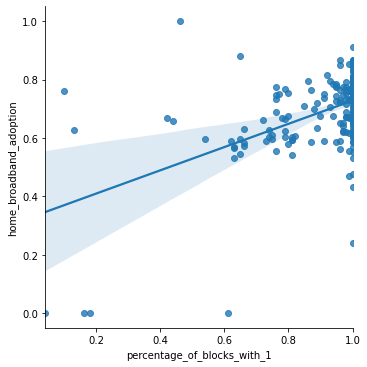

In [137]:
# Percentage of blocks with high speed fiber
sns.lmplot(data=df, x='percentage_of_blocks_with_1', y='home_broadband_adoption')
plt.show()

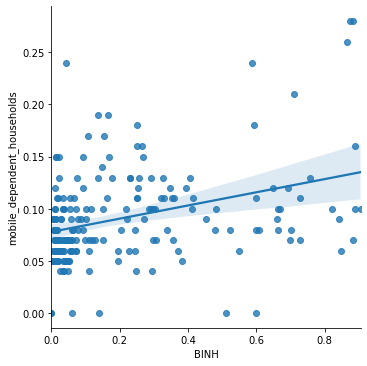

In [138]:
sns.lmplot(data=df, x='BlNH', y='mobile_dependent_households')
plt.show()

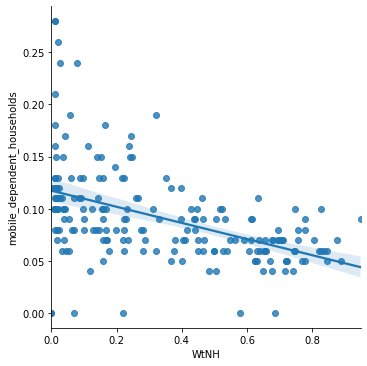

In [139]:
sns.lmplot(data=df, x='WtNH', y='mobile_dependent_households')
plt.show()

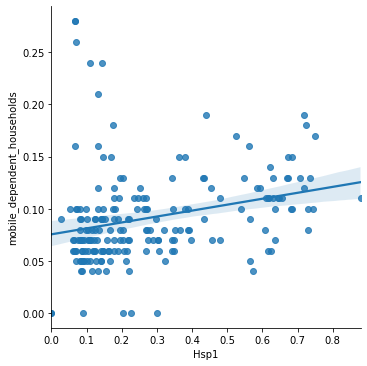

In [140]:
sns.lmplot(data=df, x='Hsp1', y='mobile_dependent_households')
plt.show()

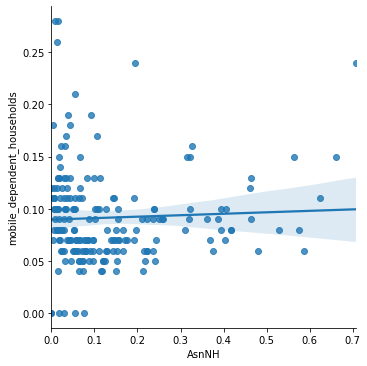

In [141]:
sns.lmplot(data=df, x='AsnNH', y='mobile_dependent_households')
plt.show()

### Relabeling and feature engineering
- "Reverse" engineer certain features for NYC totals
- Aggregate certain racial/ethnic groups

In [171]:
# Create new label pairs
pairs = [
    ('Black (non-Hispanic)', 'BlNH'),
    ('White (non-Hispanic)', 'WtNH'),
    ('Asian (non-Hispanic)', 'AsnNH'),
    ('AmInd/AmNat (non-Hispanic)', 'AIANNH'),
    ('NatHawaiian/PacIs (non-Hispanic)', 'NHPINH'),
    ('Other (non-Hispanic)', 'OthNH'),
    ('2 or more races (non-Hispanic)', 'Rc2plNH'),
    ('Hispanic (any race)', 'Hsp1'),
    ('Under 18', 'PopU181'),
    ('Mobile Dep.', 'mobile_dependent_households'),
    ('BB Adoption', 'home_broadband_adoption'),
    ('Blocks w/o Fiber', 'percentage_of_blocks_without')
]

In [172]:
# Create new DataFrames
data = pd.DataFrame()
data['Neighborhood'] = df['Neighborhood']
data['Borough'] = df['Borough']
data['GeoID'] = df['GeoID']
data['Total Population'] = df['total_population']
data['Median HH Income'] = df['Median HH Income']
data['Mean HH Income'] = df['Mean HH Income']
data['Median Fam. Income'] = df['Median Fam. Income']
totals = pd.DataFrame()
totals['Neighborhood'] = ['NYC']
totals['GeoID'] = ['None']
totals['Total Population'] = [df['total_population'].sum()]

for pair in pairs:
    col = 'Total (est.) ' + pair[0]
    col_pct = 'Share ' + pair[0]
    ori = pair[1]
    data[col_pct] = df[ori]
    data[col] = df['total_population'].values * df[ori].values
    data[col] = data[col].astype('int')
    totals[col_pct] = round(data[col].sum() / totals['Total Population'], 4)
    totals[col] = [data[col].sum()]

# Engineer aggregate race/ethnicity data
data['Share Black and/or Hispanic'] = round(
    data['Share Black (non-Hispanic)'] + data['Share Hispanic (any race)'], 4
)
totals['Share Black and/or Hispanic'] = round(
    totals['Share Black (non-Hispanic)'] + totals['Share Hispanic (any race)'], 4
)

In [173]:
# Function to flag outliers
def remove_ol(x):
    if ('99' in x) or ('98' in x):
        return 1
    else:
        return 0

# Remove outliers (ex. parks, Rikers Island)
data['Drop'] = np.vectorize(remove_ol)(data['GeoID'].values)
data = data.loc[data['Drop'] != 1]
data.drop(columns='Drop', inplace=True)

In [174]:
totals

,Neighborhood,GeoID,Total Population,Share Black (non-Hispanic),Total (est.) Black (non-Hispanic),Share White (non-Hispanic),Total (est.) White (non-Hispanic),Share Asian (non-Hispanic),Total (est.) Asian (non-Hispanic),Share AmInd/AmNat (non-Hispanic),Total (est.) AmInd/AmNat (non-Hispanic),Share NatHawaiian/PacIs (non-Hispanic),Total (est.) NatHawaiian/PacIs (non-Hispanic),Share Other (non-Hispanic),Total (est.) Other (non-Hispanic),Share 2 or more races (non-Hispanic),Total (est.) 2 or more races (non-Hispanic),Share Hispanic (any race),Total (est.) Hispanic (any race),Share Under 18,Total (est.) Under 18,Share Mobile Dep.,Total (est.) Mobile Dep.,Share BB Adoption,Total (est.) BB Adoption,Share Blocks w/o Fiber,Total (est.) Blocks w/o Fiber,Share Black and/or Hispanic
0,NYC,None,8419316,0.2229,1876663,0.3242,2729281,0.1345,1132026,0.0018,14772,0.0004,3013,0.0088,73943,0.0179,150672,0.2896,2438502,0.2117,1782073,0.094,791220,0.7005,5897571,0.1011,850974,0.5125


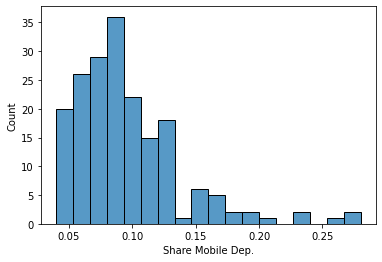

In [175]:
sns.histplot(data=data, x='Share Mobile Dep.')
plt.show()

In [205]:
def plot_cols(data, x, y, color, size, boro=None):
    if boro:
        data = data.loc[data['Borough'] == boro]

    fig = px.scatter(
        data_frame=data,
        x=x,
        y=y,
        color=color,
        size=size,
        hover_name='Neighborhood',
        hover_data=['Total Population', x, y, color, size, 'Borough'],
#         color_continuous_scale='viridis',
        title=f'{y} by {x}',
        template='plotly_dark'
    )
    
    return fig

In [206]:
plot_cols(
    data=data,
    x='Share Under 18',
    y='Share BB Adoption',
    color='Share Black and/or Hispanic',
    size=None
)